In [12]:
!pip install emoji wordcloud urlextract -q

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
from urlextract import URLExtract
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import emoji
from google.colab import files
import io

!wget -q https://raw.githubusercontent.com/campusx-official/whatsapp-chat-analysis/main/stop_hinglish.txt

In [19]:
def preprocess(data):
    # Pattern to match your specific format: [12/01/24, 6:47:02 PM]
    # Handles brackets, seconds, and the special narrow space
    pattern = '\[\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}:\d{2}[\s\u202F]?[APap][Mm]\]\s'

    messages = re.split(pattern, data)[1:]
    dates = re.findall(pattern, data)

    df = pd.DataFrame({'user_message': messages, 'message_date': dates})

    # Cleaning the date string: removing brackets and fixing the space
    def clean_date(date_str):
        date_str = date_str.strip()
        date_str = date_str.replace('[', '').replace(']', '')
        date_str = date_str.replace('\u202F', ' ') # Replaces the invisible narrow space
        date_str = date_str.strip()
        return date_str

    df['message_date'] = df['message_date'].apply(clean_date)

    # Convert to datetime using the exact format from your file
    # Format: 12/01/24, 6:47:02 PM
    try:
        df['date'] = pd.to_datetime(df['message_date'], format='%d/%m/%y, %I:%M:%S %p')
    except:
        # Fallback just in case
        df['date'] = pd.to_datetime(df['message_date'], errors='coerce')

    users = []
    messages = []
    for message in df['user_message']:
        entry = re.split('([\w\W]+?):\s', message)
        if entry[1:]:  # User Name
            users.append(entry[1])
            messages.append(" ".join(entry[2:]))
        else:
            users.append('group_notification')
            messages.append(entry[0])

    df['user'] = users
    df['message'] = messages
    df.drop(columns=['user_message', 'message_date'], inplace=True)

    df['only_date'] = df['date'].dt.date
    df['year'] = df['date'].dt.year
    df['month_num'] = df['date'].dt.month
    df['month'] = df['date'].dt.month_name()
    df['day'] = df['date'].dt.day
    df['day_name'] = df['date'].dt.day_name()
    df['hour'] = df['date'].dt.hour
    df['minute'] = df['date'].dt.minute

    period = []
    for hour in df[['day_name', 'hour']]['hour']:
        if hour == 23:
            period.append(str(hour) + "-" + str('00'))
        elif hour == 0:
            period.append(str('00') + "-" + str(hour + 1))
        else:
            period.append(str(hour) + "-" + str(hour + 1))

    df['period'] = period

    return df

<>:4: SyntaxWarning: invalid escape sequence '\['
<>:32: SyntaxWarning: invalid escape sequence '\w'
<>:4: SyntaxWarning: invalid escape sequence '\['
<>:32: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-950245508.py:4: SyntaxWarning: invalid escape sequence '\['
  pattern = '\[\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}:\d{2}[\s\u202F]?[APap][Mm]\]\s'
/tmp/ipython-input-950245508.py:32: SyntaxWarning: invalid escape sequence '\w'
  entry = re.split('([\w\W]+?):\s', message)


In [21]:
def fetch_stats(selected_user, df):
    if selected_user != 'Overall':
        df = df[df['user'] == selected_user]

    num_messages = df.shape[0]

    words = []
    for message in df['message']:
        words.extend(message.split())

    num_media_messages = df[df['message'] == '<Media omitted>\n'].shape[0]

    extractor = URLExtract()
    links = []
    for message in df['message']:
        links.extend(extractor.find_urls(message))

    return num_messages, len(words), num_media_messages, len(links)

def monthly_timeline(selected_user, df):
    if selected_user != 'Overall':
        df = df[df['user'] == selected_user]
    timeline = df.groupby(['year', 'month_num', 'month']).count()['message'].reset_index()
    time = []
    for i in range(timeline.shape[0]):
        time.append(timeline['month'][i] + "-" + str(timeline['year'][i]))
    timeline['time'] = time
    return timeline

def daily_timeline(selected_user, df):
    if selected_user != 'Overall':
        df = df[df['user'] == selected_user]
    daily_timeline = df.groupby('only_date').count()['message'].reset_index()
    return daily_timeline

def week_activity_map(selected_user, df):
    if selected_user != 'Overall':
        df = df[df['user'] == selected_user]
    return df['day_name'].value_counts()

def month_activity_map(selected_user, df):
    if selected_user != 'Overall':
        df = df[df['user'] == selected_user]
    return df['month'].value_counts()

def activity_heatmap(selected_user, df):
    if selected_user != 'Overall':
        df = df[df['user'] == selected_user]
    user_heatmap = df.pivot_table(index='day_name', columns='period', values='message', aggfunc='count').fillna(0)
    return user_heatmap

def most_busy_users(df):
    x = df['user'].value_counts().head()
    df = round((df['user'].value_counts() / df.shape[0]) * 100, 2).reset_index().rename(
        columns={'index': 'name', 'user': 'percent'})
    return x, df

def create_wordcloud(selected_user, df):
    f = open('stop_hinglish.txt', 'r')
    stop_words = f.read()

    if selected_user != 'Overall':
        df = df[df['user'] == selected_user]

    temp = df[df['user'] != 'group_notification']
    temp = temp[temp['message'] != '<Media omitted>\n']

    def remove_stop_words(message):
        y = []
        for word in message.lower().split():
            if word not in stop_words:
                y.append(word)
        return " ".join(y)

    wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')
    df_wc = wc.generate(temp['message'].apply(remove_stop_words).str.cat(sep=" "))
    return df_wc

def most_common_words(selected_user, df):
    f = open('stop_hinglish.txt', 'r')
    stop_words = f.read()

    if selected_user != 'Overall':
        df = df[df['user'] == selected_user]

    temp = df[df['user'] != 'group_notification']
    temp = temp[temp['message'] != '<Media omitted>\n']

    words = []
    for message in temp['message']:
        for word in message.lower().split():
            if word not in stop_words:
                words.append(word)

    most_common_df = pd.DataFrame(Counter(words).most_common(20))
    return most_common_df

def emoji_helper(selected_user, df):
    if selected_user != 'Overall':
        df = df[df['user'] == selected_user]

    emojis = []
    for message in df['message']:
        emojis.extend([c for c in message if c in emoji.EMOJI_DATA])

    emoji_df = pd.DataFrame(Counter(emojis).most_common(len(Counter(emojis))))
    return emoji_df

>>> PLEASE UPLOAD YOUR WHATSAPP CHAT FILE (txt)


Saving _chat.txt to _chat (3).txt
Processing _chat (3).txt...
Analyzed User: Overall
Total Messages: 657
Total Words: 4116
Media Shared: 0
Links Shared: 8

--- Monthly Timeline ---


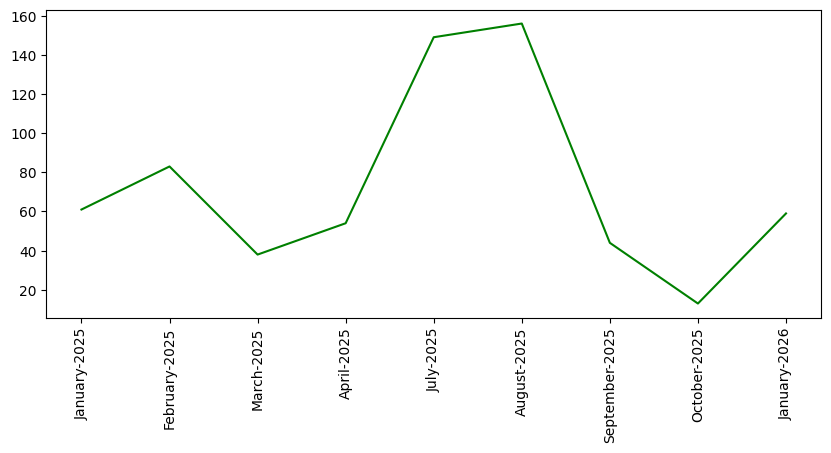


--- Daily Timeline ---


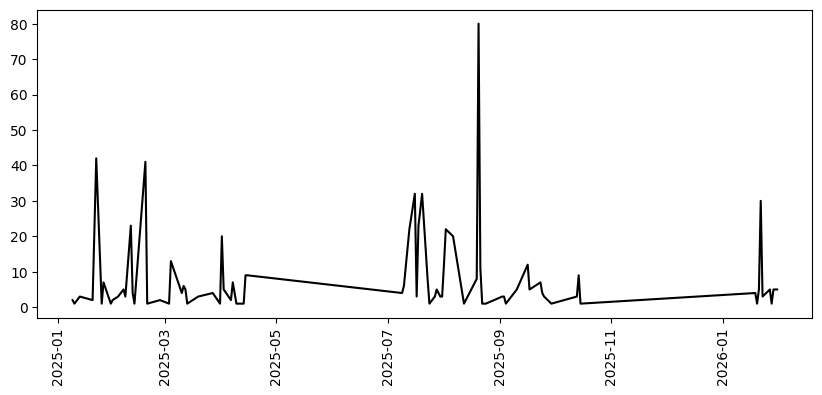


--- Activity Maps ---


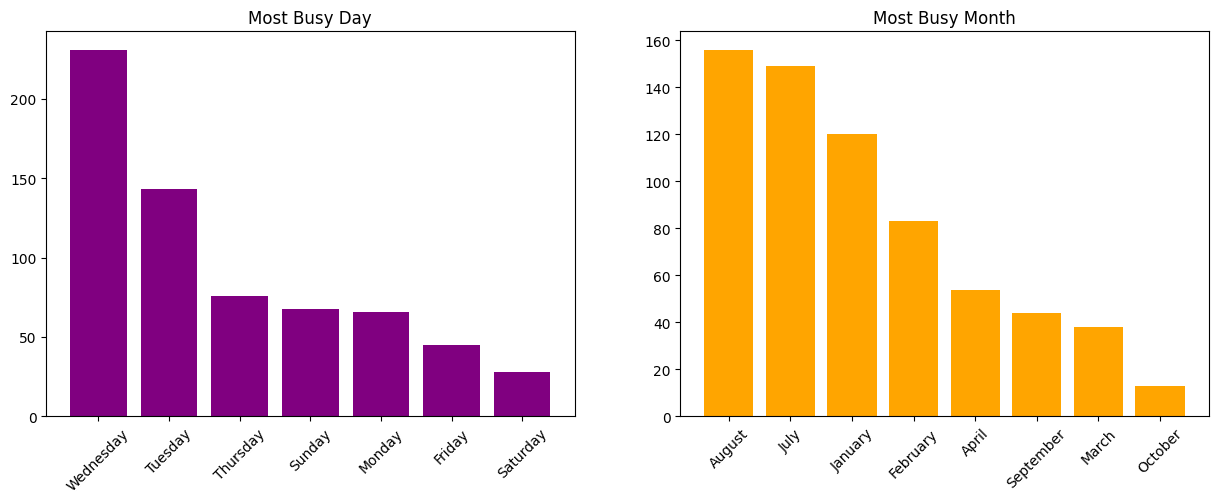


--- Weekly Activity Heatmap ---


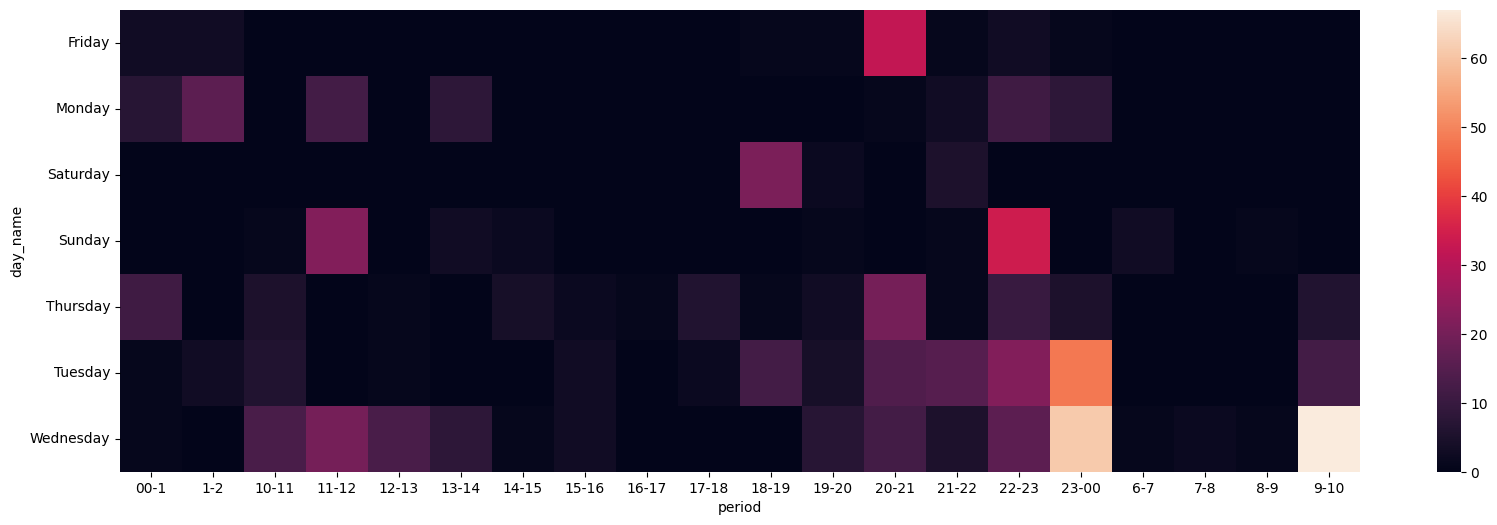


--- Most Busy Users ---


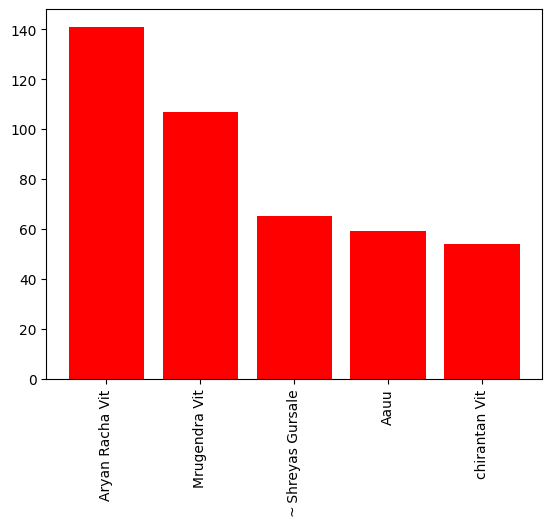

                percent  count
0       Aryan Racha Vit  21.46
1         Mrugendra Vit  16.29
2     ~ Shreyas Gursale   9.89
3                  Aauu   8.98
4         chirantan Vit   8.22
5      Shruti Gupta Vit   6.09
6             Sarah Vit   5.78
7                ~ yash   5.18
8           Aryan Kasar   4.57
9               Anirudh   3.04
10           Purvaj Vit   2.13
11   Shreyas Shetty Vit   1.52
12            Manan Vit   1.07
13  Manali Kulkarni Vit   0.91
14             Meet Vit   0.91
15       ~ Prashi Rawal   0.91
16    Shlok Rekhraj Vit   0.76
17              ~ Asees   0.61
18        CMPN-C LAB B2   0.46
19                ~ Sam   0.30
20            ~ Samudra   0.30
21   Shashwat Patil Vit   0.30
22     Daksh Sharma Vit   0.15
23         Rohan Khadye   0.15

--- Word Cloud ---


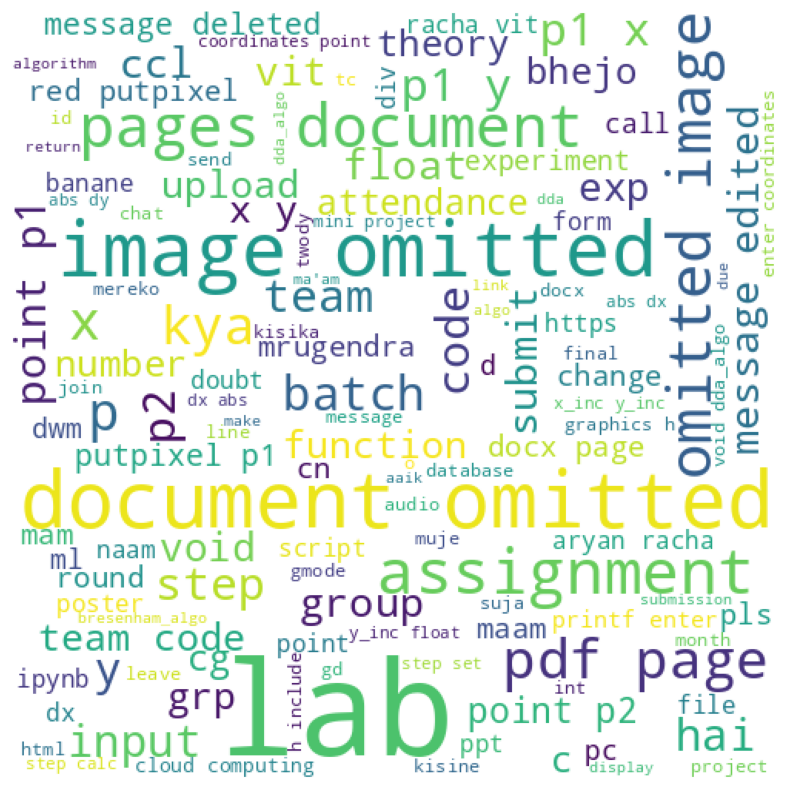


--- Most Common Words ---


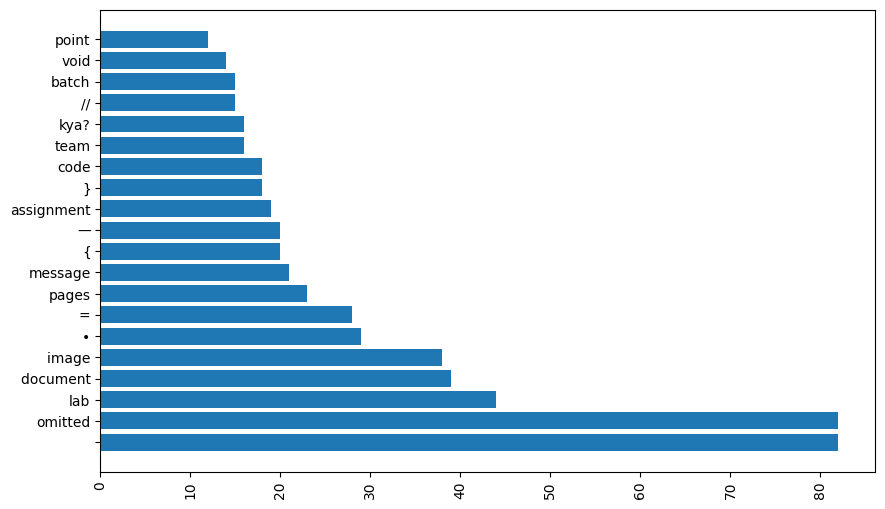


--- Emoji Analysis ---
   0   1
0  😂  16
1  🤣  11
2  😭   6
3  😅   4
4  💀   3
5  🙏   3
6  🙂   2
7  🥲   2
8  🏻   2
9  😌   2


In [23]:
# --- MAIN EXECUTION ---

print(">>> PLEASE UPLOAD YOUR WHATSAPP CHAT FILE (txt)")
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
raw_data = uploaded[file_name].decode("utf-8")

print(f"Processing {file_name}...")
df = preprocess(raw_data)

if df.empty:
    print("ERROR: No messages found! Please check if your file is a valid WhatsApp export.")
else:
    # Set User (Change "Overall" to a specific name to filter)
    selected_user = "Overall"

    print(f"Analyzed User: {selected_user}\n" + "="*30)

    # 1. Top Statistics
    num_messages, words, num_media_messages, num_links = fetch_stats(selected_user, df)
    print(f"Total Messages: {num_messages}")
    print(f"Total Words: {words}")
    print(f"Media Shared: {num_media_messages}")
    print(f"Links Shared: {num_links}")
    print("="*30)

    # 2. Monthly Timeline
    print("\n--- Monthly Timeline ---")
    timeline = monthly_timeline(selected_user, df)
    plt.figure(figsize=(10, 4))
    plt.plot(timeline['time'], timeline['message'], color='green')
    plt.xticks(rotation='vertical')
    plt.show()

    # 3. Daily Timeline
    print("\n--- Daily Timeline ---")
    d_timeline = daily_timeline(selected_user, df)
    plt.figure(figsize=(10, 4))
    plt.plot(d_timeline['only_date'], d_timeline['message'], color='black')
    plt.xticks(rotation='vertical')
    plt.show()

    # 4. Activity Maps
    print("\n--- Activity Maps ---")

    busy_day = week_activity_map(selected_user, df)
    busy_month = month_activity_map(selected_user, df)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    ax1.bar(busy_day.index, busy_day.values, color='purple')
    ax1.set_title("Most Busy Day")
    ax1.tick_params(axis='x', rotation=45)

    ax2.bar(busy_month.index, busy_month.values, color='orange')
    ax2.set_title("Most Busy Month")
    ax2.tick_params(axis='x', rotation=45)
    plt.show()

    # 5. Heatmap
    print("\n--- Weekly Activity Heatmap ---")
    try:
        user_heatmap = activity_heatmap(selected_user, df)
        plt.figure(figsize=(20, 6))
        sns.heatmap(user_heatmap)
        plt.show()
    except ValueError:
        print("Not enough data for heatmap.")

    # 6. Most Busy Users
    if selected_user == 'Overall':
        print("\n--- Most Busy Users ---")
        x, new_df = most_busy_users(df)
        fig, ax = plt.subplots()
        ax.bar(x.index, x.values, color='red')
        plt.xticks(rotation='vertical')
        plt.show()
        print(new_df)

    # 7. Word Cloud
    print("\n--- Word Cloud ---")
    try:
        df_wc = create_wordcloud(selected_user, df)
        plt.figure(figsize=(10, 10))
        plt.imshow(df_wc)
        plt.axis("off")
        plt.show()
    except:
        print("Could not generate WordCloud.")

    # 8. Most Common Words
    print("\n--- Most Common Words ---")
    most_common_df = most_common_words(selected_user, df)
    plt.figure(figsize=(10, 6))
    plt.barh(most_common_df[0], most_common_df[1])
    plt.xticks(rotation='vertical')
    plt.show()

    # 9. Emoji Analysis
    print("\n--- Emoji Analysis ---")
    emoji_df = emoji_helper(selected_user, df)
    print(emoji_df.head(10))